# G7: Sign Language digit classification using RNN

Dataset: https://www.kaggle.com/ardamavi/sign-language-digits-dataset

Hint: Recurrent Neural Network for image classification

Authors: Cécile Macaire, Ludivine Robert & Chanoudom Prach <br>
M2 Natural Language Processing

### Librairies 

In [1]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
from os import listdir
from os.path import isfile, join
import imageio
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Step 1. Preprocess the data as per the given task

The data are images with sign digit language. <br>
Each sign language number is in a specific folder. <br>
Image size: 100x100 <br>
Color: RGB

Before running the given algorithm, we had to retrieve 3 images from folder 7: 5874, 5935 and 5978.

### Step 2. Write custom dataloader and collate function for creating train dataset and test dataset

In [3]:
# Path to the images
path_images = '/media/macaire/Ubuntu/Master_2/Neural_Networks/sign-language-digit-classification/Dataset/'


class SignDataset(Dataset):
    """SignDataset class to read the dataset
    Inherit from torch.utils.data.Dataset
    functions: init, len, getitem and find_files"""
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            image_files : Dictionary with all files and their given label
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.image_files = self._find_files()
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        elements = list(self.image_files.items())  # get all files
        image = io.imread(elements[index][0])  # retrieve the file from specific index
        label = torch.tensor(int(elements[index][1]))  # transform the label into tensor
        if self.transform:
            image = self.transform(image)  # transform image
        return (image, label)
    
    
    def _find_files(self):
        """Recursively finds all files matching the pattern."""
        files = {}
        for i in range(0,10):
            images = [f for f in listdir(self.root_dir+'/'+str(i)) if isfile(join(self.root_dir+'/'+str(i), f))]
            for el in images:
                files[self.root_dir+str(i)+'/'+el] = i
        return files

    
class SignCollate(object):
    """Function object used as a collate function for DataLoader."""
    def __init__(self, ):
        pass
        
    def _collate_fn(self, batch):
        new_batch = []
        for idx in range(len(batch)):
            sample = batch[idx][0]
            label = batch[idx][1]
            new_batch.append(sample)

        # scalar output
        sample_batch = np.array(new_batch)
        sample_batch = torch.FloatTensor(sample_batch)
       
        return sample_batch

    def __call__(self, batch):
        return self._collate_fn(batch)

In [4]:
dataset = SignDataset(root_dir=path_images, transform=transforms.ToTensor())  # access to the dataset
print(len(dataset))  # 2059 images

collate_fn = SignCollate()

batch_size = 32

# Split into TRAIN and TEST
train_size = int(0.9 * len(dataset))  # 90% of the data for train set
test_size = len(dataset) - train_size  # 10 % of the data for test set
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])


# Create the train and test loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

2059


### Step 3. Define the neural network model in pytorch

In [5]:
# Neural Network model -> Recurrent Neural Network (RNN)
class RNN_LSTM_classifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNN_LSTM_classifier, self).__init__()
        self.rnn = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.out = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        r_out, (_, _) = self.rnn(x, None)  # forward propagate lstm
        # Decode the hidden state of the last time step
        out = self.out(r_out[:, -1, :]) # out: tensor of shape (batch_size, hidden_size)
        return out

### Step 4. Define hyperparameters to create instance of neural network model as well as parameters required to train neural network

In [12]:
# Hyperparameters
num_layers = 2
# sequence_length = 32
input_size = 100  # size of the input image
hidden_size = 64  
num_classes = 10   # 10 classes (digits from 0 to 9)
num_epochs = 150   # for the training
learning_rate = 0.01

### Step 5. Write training loop for training the model

In [13]:
model = RNN_LSTM_classifier(input_size, hidden_size, num_classes).to(device)

In [14]:
# Loss and optimizer for RNN
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        images = images.reshape(-1, 300, input_size).to(device)  # need to reshape the images: 300 = 3*100 (rgb, input_size)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/150], Step [10/58], Loss: 2.3851
Epoch [1/150], Step [20/58], Loss: 2.2879
Epoch [1/150], Step [30/58], Loss: 2.3039
Epoch [1/150], Step [40/58], Loss: 2.3536
Epoch [1/150], Step [50/58], Loss: 2.1438
Epoch [2/150], Step [10/58], Loss: 2.0261
Epoch [2/150], Step [20/58], Loss: 2.3327
Epoch [2/150], Step [30/58], Loss: 2.1955
Epoch [2/150], Step [40/58], Loss: 2.2962
Epoch [2/150], Step [50/58], Loss: 2.2760
Epoch [3/150], Step [10/58], Loss: 2.2432
Epoch [3/150], Step [20/58], Loss: 2.1145
Epoch [3/150], Step [30/58], Loss: 1.9805
Epoch [3/150], Step [40/58], Loss: 1.9984
Epoch [3/150], Step [50/58], Loss: 2.1866
Epoch [4/150], Step [10/58], Loss: 1.9800
Epoch [4/150], Step [20/58], Loss: 2.1915
Epoch [4/150], Step [30/58], Loss: 2.4481
Epoch [4/150], Step [40/58], Loss: 2.1986
Epoch [4/150], Step [50/58], Loss: 2.0036
Epoch [5/150], Step [10/58], Loss: 2.1545
Epoch [5/150], Step [20/58], Loss: 2.1713
Epoch [5/150], Step [30/58], Loss: 2.0854
Epoch [5/150], Step [40/58], Loss:

Epoch [39/150], Step [30/58], Loss: 1.7627
Epoch [39/150], Step [40/58], Loss: 1.5537
Epoch [39/150], Step [50/58], Loss: 1.6194
Epoch [40/150], Step [10/58], Loss: 1.5260
Epoch [40/150], Step [20/58], Loss: 1.4493
Epoch [40/150], Step [30/58], Loss: 1.7386
Epoch [40/150], Step [40/58], Loss: 1.5322
Epoch [40/150], Step [50/58], Loss: 1.4110
Epoch [41/150], Step [10/58], Loss: 1.7378
Epoch [41/150], Step [20/58], Loss: 1.5019
Epoch [41/150], Step [30/58], Loss: 2.0782
Epoch [41/150], Step [40/58], Loss: 1.8856
Epoch [41/150], Step [50/58], Loss: 1.7890
Epoch [42/150], Step [10/58], Loss: 1.4695
Epoch [42/150], Step [20/58], Loss: 1.7614
Epoch [42/150], Step [30/58], Loss: 1.6485
Epoch [42/150], Step [40/58], Loss: 1.7906
Epoch [42/150], Step [50/58], Loss: 1.6742
Epoch [43/150], Step [10/58], Loss: 2.0978
Epoch [43/150], Step [20/58], Loss: 1.6793
Epoch [43/150], Step [30/58], Loss: 1.5181
Epoch [43/150], Step [40/58], Loss: 2.0206
Epoch [43/150], Step [50/58], Loss: 1.6483
Epoch [44/1

Epoch [77/150], Step [40/58], Loss: 1.5533
Epoch [77/150], Step [50/58], Loss: 1.3950
Epoch [78/150], Step [10/58], Loss: 1.3013
Epoch [78/150], Step [20/58], Loss: 1.2200
Epoch [78/150], Step [30/58], Loss: 1.7678
Epoch [78/150], Step [40/58], Loss: 1.1372
Epoch [78/150], Step [50/58], Loss: 1.4665
Epoch [79/150], Step [10/58], Loss: 1.3595
Epoch [79/150], Step [20/58], Loss: 1.2556
Epoch [79/150], Step [30/58], Loss: 1.4137
Epoch [79/150], Step [40/58], Loss: 1.1486
Epoch [79/150], Step [50/58], Loss: 1.4093
Epoch [80/150], Step [10/58], Loss: 1.4666
Epoch [80/150], Step [20/58], Loss: 1.3829
Epoch [80/150], Step [30/58], Loss: 1.5485
Epoch [80/150], Step [40/58], Loss: 1.4248
Epoch [80/150], Step [50/58], Loss: 1.2564
Epoch [81/150], Step [10/58], Loss: 1.3757
Epoch [81/150], Step [20/58], Loss: 1.4161
Epoch [81/150], Step [30/58], Loss: 1.3375
Epoch [81/150], Step [40/58], Loss: 1.4746
Epoch [81/150], Step [50/58], Loss: 1.4499
Epoch [82/150], Step [10/58], Loss: 1.3685
Epoch [82/1

Epoch [115/150], Step [30/58], Loss: 1.1035
Epoch [115/150], Step [40/58], Loss: 0.9823
Epoch [115/150], Step [50/58], Loss: 1.1908
Epoch [116/150], Step [10/58], Loss: 1.4621
Epoch [116/150], Step [20/58], Loss: 1.5157
Epoch [116/150], Step [30/58], Loss: 1.3347
Epoch [116/150], Step [40/58], Loss: 1.1398
Epoch [116/150], Step [50/58], Loss: 1.5019
Epoch [117/150], Step [10/58], Loss: 1.3308
Epoch [117/150], Step [20/58], Loss: 1.4224
Epoch [117/150], Step [30/58], Loss: 1.6156
Epoch [117/150], Step [40/58], Loss: 1.1438
Epoch [117/150], Step [50/58], Loss: 1.2534
Epoch [118/150], Step [10/58], Loss: 1.1882
Epoch [118/150], Step [20/58], Loss: 1.2767
Epoch [118/150], Step [30/58], Loss: 1.3827
Epoch [118/150], Step [40/58], Loss: 1.2746
Epoch [118/150], Step [50/58], Loss: 1.5638
Epoch [119/150], Step [10/58], Loss: 1.6477
Epoch [119/150], Step [20/58], Loss: 1.2084
Epoch [119/150], Step [30/58], Loss: 1.5740
Epoch [119/150], Step [40/58], Loss: 1.0624
Epoch [119/150], Step [50/58], L

### Step 6. Evaluate the model on test data. In this part, it is expected to choose appropriate evaluation metrics based on your task. For an instance, for classification task, accuracy, precision and recall should be computed

In [16]:
# Test the model
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 300, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    # Because it is a classification task, we print the accuracy, precision and recall  
    print('Test Accuracy of the model on the 10000 test images: {} %'.format(round((100 * correct / total), 2))) 
    print('Precision: {} %'.format(round(torch.tensor(precision_score(labels,predicted, average='weighted')).item()*100, 2)))
    print('Recall: {} %'.format(round(torch.tensor(recall_score(labels,predicted, average='weighted')).item()*100, 2)))

Test Accuracy of the model on the 10000 test images: 47.09 %
Precision: 25.0 %
Recall: 28.57 %


/home/macaire/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/macaire/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## Comments

We trained different models with several parameters (number of epochs, batch size, hidden_size) on different computers but the accuracy we got was always between 30% and 65%. <br>
During this training, with 150 epochs, the accuracy is equal to almost 50%. <br>
By improving the RNN model and the number of epochs, we could think of getting better results. 

### Step 7. Save the obtained results

Predicted label:  5
Correct label:  5


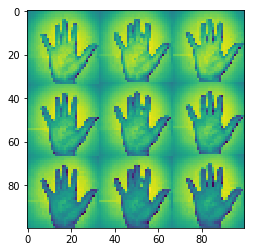

---------------------------
Predicted label:  8
Correct label:  6


---------------------------
Predicted label:  5
Correct label:  5


---------------------------
Predicted label:  1
Correct label:  6


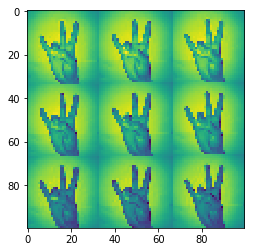

---------------------------
Predicted label:  8
Correct label:  2


---------------------------
Predicted label:  0
Correct label:  0


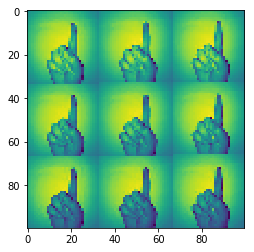

---------------------------
Predicted label:  7
Correct label:  8


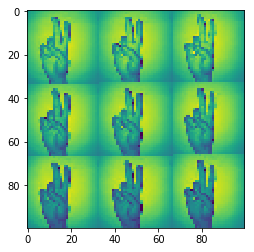

---------------------------


In [23]:
# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
for i, (images, labels) in enumerate(test_loader):
#     print(images.shape)
#     print(images)
    show_image = images.reshape(-1, 100, 100, 3).to(device)
    x_np = show_image.numpy()
    plt.imshow(x_np[0][:,:,1])
    images = images.reshape(-1, 300, input_size).to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    print('Predicted label: ', int(predicted[i]))
    print('Correct label: ', int(labels[i]))
    plt.show()
#     print(images.shape)
    print('---------------------------')